In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cbsyst as cb
import pandas as pd
# you may need to change this, depending on where your data file is
filename = 'wcoa_cruise/WCOA2013_hy1.csv' 
df = pd.read_csv(filename,header=31,na_values=-999,
                 parse_dates=[[8,9]])

# It will use defaults for some missing values. We use the max.
Csw = cb.Csys(pH=df['PH_TOT'], TA=df['ALKALI'], T=df['CTDTMP'], S=df['CTDSAL'], P=df['CTDPRS'])
# Some keys have their own keys.
print(Csw.keys())

# Calculate OmegaA and add it to the existing pandas dataframe
df['OmegaA'] = Csw['Ca']*Csw['CO3']/(Csw.Ks['KspA']*1e6)

# Create an index referencing just values between 30 and 300 meters, and eliminating
# values which are not real numbers.
index = ((df['CTDPRS'] >= 30) & (df['CTDPRS'] <= 300) & np.isfinite(df['OmegaA']+
         df['OXYGEN']+df['CTDTMP']+df['CTDSAL']+df['CTDPRS']+df['NITRAT']))

print('There are ', sum(index), ' good values of', len(df), 'in the dataframe.')


dict_keys(['unit', 'Ks', 'TSi', 'TP', 'P', 'S', 'T', 'Mg', 'Ca', 'BT', 'pCO2', 'fCO2', 'TA', 'CO3', 'HCO3', 'CO2', 'DIC', 'pH', 'TS', 'TF', 'H', 'CAlk', 'BAlk', 'PAlk', 'SiAlk', 'OH', 'Hfree', 'HSO4', 'HF'])
There are  291  good values of 972 in the dataframe.


In [2]:
# Now put the values into variables for use with the equation Ax = y where A is the
# expanatory variable matrix and y is the response variable.
# Response variable is the aragonite vector.
omegaA = df[index]['OmegaA']
# The explanatory variable matrix will contain the values needed in
# OmegaA = c0 + c1 x T + c2 x S + c3 x P + c5 x O + c6 x N
# T, S, P, O, N
# Rows - one per data value (290 values in this case)
# Columns - one per input variable, plus one for C0
A1 = np.ones([len(omegaA), 6])*np.nan
A1[:, 0] = 1
A1[:, 1] = df[index]['CTDTMP']
A1[:, 2] = df[index]['CTDSAL']
A1[:, 3] = df[index]['CTDPRS']
A1[:, 4] = df[index]['OXYGEN']
A1[:, 5] = df[index]['NITRAT']

# Linear regression for the coefficients (vector x in Ax = y)
regression1 = np.linalg.lstsq(A1, omegaA, rcond=None)
print(regression1[0])

[-2.92426712e-01  3.19511048e-02  2.76126826e-02  2.05413668e-04
  1.15334506e-03 -1.90468799e-02]


<IPython.core.display.Javascript object>


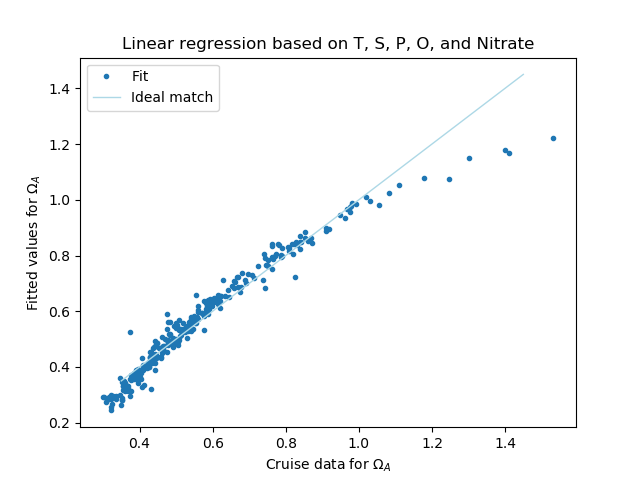

<IPython.core.display.Javascript object>


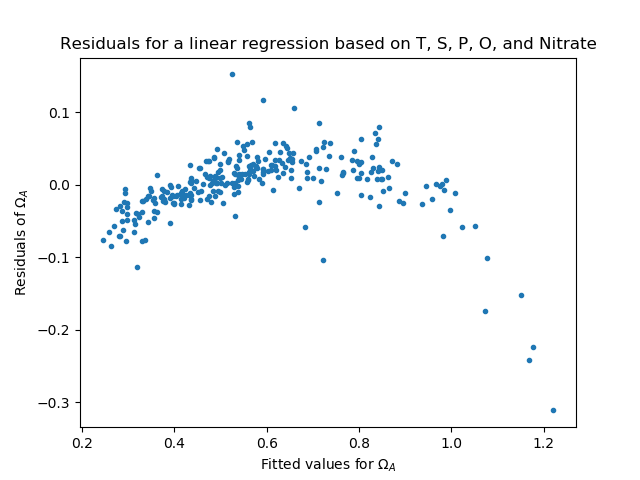

Text(0.5,1,'Residuals for a linear regression based on T, S, P, O, and Nitrate')

In [23]:
# Calculate OmegaA from the result for plotting
# Use the vector of C0, C1, ... CN times each row of A
Omega_fit = np.dot(A1, regression1[0])  #A @ regression[0]

# Plot the fit
plt.figure()
plt.plot(omegaA, Omega_fit, '.', label = 'Fit')
# Add a line to help see how close this is.
plt.plot([0.35, 1.45], [0.35, 1.45], '-', color='lightblue', linewidth=1, label='Ideal match')
plt.xlabel('Cruise data for $\Omega _A$')
plt.ylabel('Fitted values for $\Omega _A$')
plt.title('Linear regression based on T, S, P, O, and Nitrate')
plt.legend()

# Now the residuals.  I'll use omega as x, as in Juranek.
resid = Omega_fit - omegaA
plt.figure()
plt.plot(Omega_fit, resid, '.')
plt.ylabel('Residuals of $\Omega _A$')
plt.xlabel('Fitted values for $\Omega _A$')
plt.title('Residuals for a linear regression based on T, S, P, O, and Nitrate')

In [4]:
# Now a second regression using just O and its interaction with T.
# The new explanatory variable matrix will contain the values needed in
# OmegaA = c0 + c1 x (O - Oref) + c2 x (O - Oref)*(T - Tref)
# The reference values from the March 6 handout are
o_ref = 140  # umol/kg
t_ref = 8    # degrees C
# Rows - one per data value (290 values in this case)
# Columns - one for each term in the OmegaA equation.
A2 = np.ones([len(omegaA), 3])*np.nan
A2[:, 0] = 1
A2[:, 1] = df[index]['OXYGEN'] - o_ref
A2[:, 2] = np.multiply(A2[:, 1], df[index]['CTDTMP'] - t_ref)

# Linear regression for the coefficients (vector x in Ax = y)
regression2 = np.linalg.lstsq(A2, omegaA, rcond=None)
print(regression2[0])

[0.57465646 0.00286232 0.00063564]


<IPython.core.display.Javascript object>


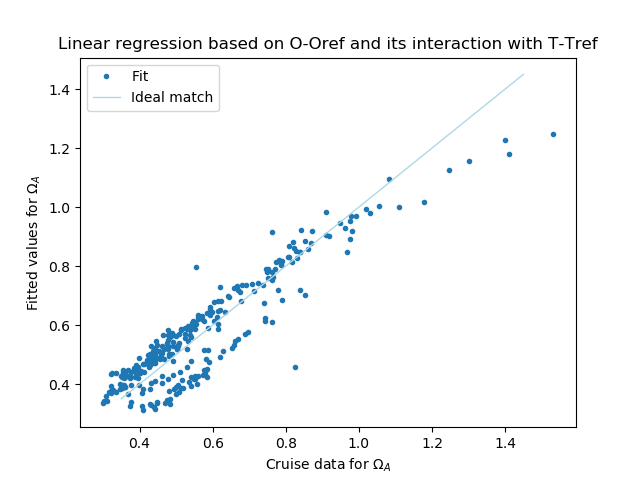

<IPython.core.display.Javascript object>


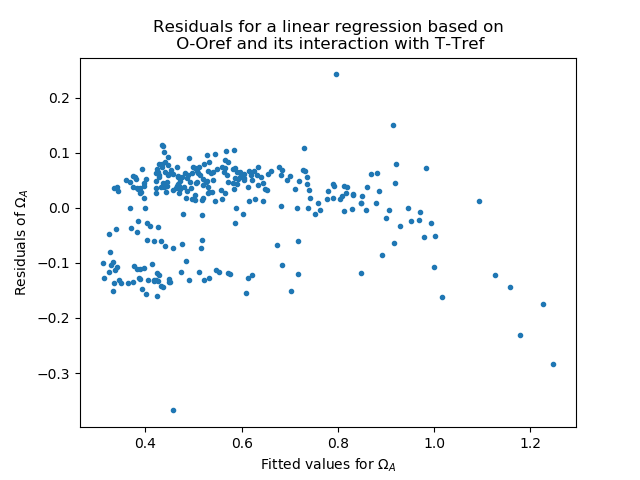

Text(0.5,1,'Residuals for a linear regression based on\n O-Oref and its interaction with T-Tref')

In [24]:
# Calculate OmegaA from the result for plotting
# Use the vector of C0, C1, ... CN times each row of A
Omega_fit_interact = np.dot(A2, regression2[0]) 

# Plot fit versus data, as before.
plt.figure()
plt.plot(df[index]['OmegaA'], Omega_fit_interact, '.',  label = 'Fit')
plt.plot([0.35, 1.45], [0.35, 1.45], '-', color='lightblue', linewidth=1,  label = 'Ideal match')
plt.xlabel('Cruise data for $\Omega _A$')
plt.ylabel('Fitted values for $\Omega _A$')
plt.title('Linear regression based on O-Oref and its interaction with T-Tref')
plt.legend()

# Now the residuals
resid_interact = Omega_fit_interact - omegaA
plt.figure()
plt.plot(Omega_fit_interact, resid_interact, '.')
plt.ylabel('Residuals of $\Omega _A$')
plt.xlabel('Fitted values for $\Omega _A$')
plt.title('Residuals for a linear regression based on\n O-Oref and its interaction with T-Tref')

In [25]:
# Use a library function to look at the signifcance of the fit.
# It's interesting that the regression results aren't used here.  It must
# be repeating the calculation.

import statsmodels.api as sm
print("Tests for the original function of T, S, P, O, and N")
res = sm.OLS(omegaA, A1).fit()
print(res.summary())

print("\n\nTests for the fit based on O and T\n")
res = sm.OLS(omegaA, A2).fit()
print(res.summary())

Tests for the original function of T, S, P, O, and N
                            OLS Regression Results                            
Dep. Variable:                 OmegaA   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1064.
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          5.38e-182
Time:                        13:03:12   Log-Likelihood:                 479.03
No. Observations:                 291   AIC:                            -946.1
Df Residuals:                     285   BIC:                            -924.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

Both regressions show high significance based on their F-statistics of 1,073 and 793 respectively.  However, the second model shows much tighter confidence intervals for the individual coefficients.  It is interesting that the R-squared of the second model is quite a bit lower than the first (0.847 vs. 0.950), although the table from Juranek et al. shows the opposite (0.987 vs.0.966).  

Multiple co-linearity refers to the ability to predict one of the input variables from the others. This could have been expected in the original model after seeing the plots we did in class, several of which look very similar.  This leads to unpredictability in the selection of coefficients, even if the model is valid.  Both of the model equations seem applicable in terms of giving a fairly good prediction of Omega A for this cruise.  I am not convinced that the model would apply in other parts of the world, since temperature and oxygen seem unlikely to be the biggest cause-and-effect determinants of aragonite concentration.

The second regression seems to have gap between a grouping of points with positive residuals and another with negative residuals.  It would be interesting to see if there is some variable which distinguishes these two groups.

Significant numerical errors seem relatively unlikely here, especially in the second case.  The oxygen values range between 36.4 and 283 while T goes from 6.2 to 12.7 degrees, both of which seem reasonable.  Assuming that the linear algebra library is well designed, there should be no reason for important errors to build up.